Our goal is to capture alpha in the stock markets.

In this research, we will apply simple mean-reverting strategy on MAMAA stocks (MSFT, APPL, META, AMZN, GOOG) to create entry and exit signals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Parameter control

In [31]:
start_date = '2012-07-31'
end_date = '2022-07-31'

## Data wrangling

In [16]:
def get_close_price(ticker):
    df = pd.read_csv(f'data/{ticker}.csv')
    df.set_index('Date', inplace=True)
    price = df['Close']
    price.rename(f'{ticker.upper()}', inplace=True)
    return price

In [18]:
msft = get_close_price('MSFT')
df_mamaa = pd.DataFrame(msft)
df_mamaa.head()

,MSFT
Date,
2008-12-31,14.58
2009-01-02,15.24
2009-01-05,15.39
2009-01-06,15.57
2009-01-07,14.63


In [19]:
# get the rest of the tickers
stock_list = ['AAPL', 'META', 'AMZN', 'GOOG']

for stock in stock_list:
    df_stock = get_close_price(stock)
    df_mamaa = pd.merge(df_mamaa, df_stock, on='Date')

print(df_mamaa)

              MSFT    AAPL    META    AMZN    GOOG
Date                                              
2012-05-18   23.85   16.17   38.23   10.69   14.95
2012-05-21   24.24   17.12   34.03   10.91   15.30
2012-05-22   24.25   16.98   31.00   10.77   14.96
2012-05-23   23.72   17.40   32.00   10.86   15.18
2012-05-24   23.69   17.24   33.03   10.76   15.04
...            ...     ...     ...     ...     ...
2022-07-25  258.28  152.74  166.65  121.14  108.21
2022-07-26  251.37  151.39  159.15  114.81  105.44
2022-07-27  268.17  156.57  169.58  120.97  113.60
2022-07-28  275.82  157.13  160.72  122.28  114.59
2022-07-29  280.15  162.28  159.10  134.95  116.64

[2566 rows x 5 columns]


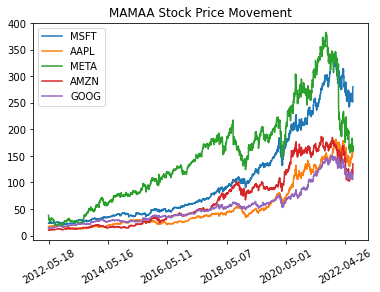

In [40]:
plt.plot(df_mamaa['MSFT'], label='MSFT')
plt.plot(df_mamaa['AAPL'], label='AAPL')
plt.plot(df_mamaa['META'], label='META')
plt.plot(df_mamaa['AMZN'], label='AMZN')
plt.plot(df_mamaa['GOOG'], label='GOOG')
plt.xticks(np.arange(0, len(df_mamaa.index), 500), rotation=30)
plt.title('MAMAA Stock Price Movement')
plt.legend()
plt.show()

## Strategy

In [21]:
# calculate daily return
df_daily_return = df_mamaa.pct_change()
df_daily_return.head()

,MSFT,AAPL,META,AMZN,GOOG
Date,,,,,
2012-05-18,NaN,NaN,NaN,NaN,NaN
2012-05-21,0.016352,0.058751,-0.109861,0.020580,0.023411
2012-05-22,0.000413,-0.008178,-0.089039,-0.012832,-0.022222
2012-05-23,-0.021856,0.024735,0.032258,0.008357,0.014706
2012-05-24,-0.001265,-0.009195,0.032188,-0.009208,-0.009223


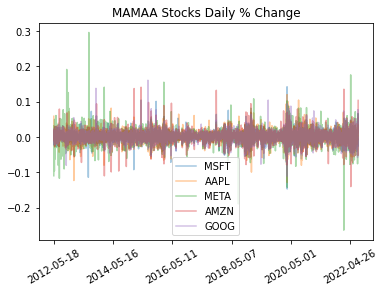

In [44]:
plt.plot(df_daily_return['MSFT'], label='MSFT', alpha=0.4)
plt.plot(df_daily_return['AAPL'], label='AAPL', alpha=0.4)
plt.plot(df_daily_return['META'], label='META', alpha=0.4)
plt.plot(df_daily_return['AMZN'], label='AMZN', alpha=0.4)
plt.plot(df_daily_return['GOOG'], label='GOOG', alpha=0.4)
plt.xticks(np.arange(0, len(df_daily_return.index), 500), rotation=30)
plt.title('MAMAA Stocks Daily % Change')
plt.legend()
plt.show()

Assume our portfolio is equally-weighted

In [22]:
# calculate equal-weighted daily return
portfolio_daily_return = df_daily_return.mean(axis=1)
portfolio_daily_return

Date
2012-05-18         NaN
2012-05-21    0.001847
2012-05-22   -0.026372
2012-05-23    0.011640
2012-05-24    0.000659
                ...   
2022-07-25   -0.008123
2022-07-26   -0.031690
2022-07-27    0.059526
2022-07-28   -0.000120
2022-07-29    0.031980
Length: 2566, dtype: float64

In [32]:
# calculate average portfolio daily return
avg_portfolio_daily_return = np.mean(portfolio_daily_return)
avg_portfolio_daily_return

0.0010285105190968404

The portfolio of the MAMAA stocks has a 0.103% daily return for the past 10 years, not bad

In [23]:
# calculate weight of each stock, which is proportional to the negative distance to the portfolio
weights = -(np.array(df_daily_return) - np.array(portfolio_daily_return).reshape((df_daily_return.shape[0], 1)))
weights

array([[        nan,         nan,         nan,         nan,         nan],
       [-0.01450561, -0.05690418,  0.11170796, -0.01873339, -0.02156478],
       [-0.02678426, -0.01819415,  0.06266736, -0.01353946, -0.0041495 ],
       ...,
       [-0.00730785,  0.02530964, -0.00600975,  0.00587204, -0.01786408],
       [-0.02864657, -0.00369657,  0.05212684, -0.01094902, -0.00883468],
       [ 0.01628114, -0.00079562,  0.04205943, -0.07163487,  0.01408992]])

In [24]:
# calculate sum of weights
sum_weights = np.nansum(abs(weights), axis=1)
sum_weights

array([0.        , 0.22341592, 0.12533473, ..., 0.06236336, 0.10425367,
       0.14486098])

In [26]:
# exclude stocks that do not have valid prices or daily returns
weights[sum_weights == 0] = 0
sum_weights[sum_weights == 0] = 1

weights = weights / sum_weights.reshape((df_daily_return.shape[0], 1))
weights

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.06492648, -0.25470066,  0.5       , -0.08384984, -0.09652302],
       [-0.21370183, -0.14516447,  0.5       , -0.10802637, -0.03310732],
       ...,
       [-0.11718173,  0.4058415 , -0.09636674,  0.0941585 , -0.28645153],
       [-0.27477757, -0.03545741,  0.5       , -0.10502288, -0.08474214],
       [ 0.1123915 , -0.00549231,  0.29034339, -0.49450769,  0.09726511]])

In [27]:
# calculate daily portfolio P&L
df_weights = pd.DataFrame(weights)

daily_pnl = np.nansum(np.array(df_weights.shift()) * np.array(df_daily_return), axis=1)
daily_pnl

array([ 0.        ,  0.        , -0.03924255, ...,  0.00579623,
        0.00166689, -0.02291352])

In [29]:
# remove date outside of interest
daily_pnl = daily_pnl[np.logical_and(df_mamaa.index >= start_date, df_mamaa.index <= end_date)]

In [30]:
# calculate Sharpe ratio
sharpe_ratio = np.sqrt(252) * np.mean(daily_pnl) / np.std(daily_pnl)
sharpe_ratio

-0.0435631893591652

Sharpe ratio for this strategy is negative, and it's before any transaction costs, making this strategy unattractive

## Further work

- As all stocks in the portfolio are in the large-cap Tech sector, we see that they tend to move in the same direction in the first graph => it may be better to use momentum strategy rather than mean-reverting strategy on their price movement
- This leads to a discussion that perhaps the mean-reverting strategy fits better with inputs such as their daily return, as suggested in the second graph